<a href="https://colab.research.google.com/github/aekanun2020/2022-PSU-Data-Science-for-Tourism-Course2/blob/main/SENT_Student_Prediction_of_Customer_Behavior_onColab_PARTIALRev3_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Spark Environment

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
from pyspark.sql import SparkSession

In [5]:
sc = spark.sparkContext

In [6]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Libraries and Modules Installation

In [7]:
#Spark
from pyspark.sql import functions as sparkf
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#Python
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from functools import reduce

# 1. Business Understanding

**ธุรกิจต้องการได้รับ Machine Learning Model ที่ทำให้ทราบล่วงหน้าว่า ลูกค้าที่กำลังเลือกดูสินค้าอยู่ จะซื้อหรือไม่ซื้อสินค้าหรือไม่ (Binary Classification)**

(1) ไม่สนใจ timeOnScreen เนื่องจาก การ run รอบแรก ทำให้ที่ .describe() ว่าไม่มีค่าอะไรเลยใน attribute นี้
(2) ไม่สนใจ hitReferer เนื่องจาก เป็น url ซึ่งเห็นจากการ run รอบแรก ที่เห็นช่วงข้อมูลจาก .describe() 

In [8]:
business_NotRequired_col_list = [\
                        #'sourceKeyword'\
                        #,'fullVisitorId'\
                        #,'isVideoAd'\
                        #,'date'\
                        #,'isTrueDirect'\
                        #,'hitHour'\
                        #,'hitMin'\
                        #,'isClick'\
                        #,'productListName'\
                        #,'isImpression'\
                        #,'sessionQualityDim'\
                        'timeOnScreen'\
                        ,'hitReferer'
                        #,'medium'
                        #,'hitType'
                        ]

# 2. Data Understanding

### **2.1 Data Collection and Previewing Data**

In [9]:
! wget https://storage.googleapis.com/class25jan2022/share/testfunnel.csv

--2022-03-05 05:27:44--  https://storage.googleapis.com/class25jan2022/share/testfunnel.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 142.251.107.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1501012 (1.4M) [text/csv]
Saving to: ‘testfunnel.csv’

testfunnel.csv      100%[===================>]   1.43M  --.-KB/s    in 0.02s   

2022-03-05 05:27:44 (80.0 MB/s) - ‘testfunnel.csv’ saved [1501012/1501012]



In [10]:
! head -3 testfunnel.csv

source,isTrueDirect,sourceKeyword,medium,isVideoAd,fullVisitorId,visitId,date,newVisits,hitReferer,hitType,hitAction_type,hitNumber,hitHour,hitMin,timeMicroSec,v2ProductName,productListName,isClick,isImpression,sessionQualityDim,timeOnScreen,timeOnSite,totalTransactionRevenue
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,28,15,46,608771,Google Accent Insulated Stainless Steel Bottle,Category,,true,,,1897,
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,27,15,46,605064,Google Pocket Bluetooth Speaker,Category,,true,,,1897,


In [11]:
! wc -l testfunnel.csv

10000 testfunnel.csv


In [12]:
source_df = spark.read.option('header','true')\
.option("inferSchema" , "true")\
.format('csv').load('./testfunnel.csv')

In [13]:
raw_df = source_df.select([ col for col in source_df.columns if col not in business_NotRequired_col_list ])

In [14]:
business_NotRequired_col_list

['timeOnScreen', 'hitReferer']

In [15]:
len(raw_df.columns)

22

In [16]:
raw_df.sample(0.001).limit(5).toPandas().transpose()

,0,1,2,3,4
source,(direct),google,(direct),(direct),(direct)
isTrueDirect,None,None,None,True,True
sourceKeyword,None,(not provided),None,None,None
medium,(none),organic,(none),(none),(none)
isVideoAd,None,None,None,None,None
fullVisitorId,4990075466656363861,4990095180157260404,4990634493822624181,4991710110216617350,499181803050305114
visitId,1480486355,1493943683,1492621822,1471605830,1492037213
date,20161129,20170504,20170419,20160819,20170412
newVisits,1,1,1,1,1
hitType,PAGE,PAGE,PAGE,PAGE,PAGE


In [17]:
raw_df.printSchema()

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: boolean (nullable = true)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: boolean (nullable = true)
 |-- isImpression: boolean (nullable = true)
 |-- sessionQualityDim: integer (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransactionRevenue: integer (nullable = true)



### **2.2 Univariate Analysis**



*ตรวจดูว่า (1) มี Missing Values แบบ NULL หรือ Empty Value หรือไม่ (2) มี Dispersion สูงหรือไม่ (3) Range ว่าถูกต้อง หรือกว้างมากเกินไปหรือไม่ (high range)*



*ระวังว่า .describe() ไม่ประมวลผล type: Boolean*

In [18]:
raw_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,9999,None,None,(direct),youtube.com
sourceKeyword,4042,None,None,(not provided),youtube merch
medium,9999,None,None,(none),referral
fullVisitorId,9999,4.5067648825526333E18,1.39995873491150899E18,49898505875812980,4995924842281653133
visitId,9999,1.4850613864552455E9,9020666.664979974,1470106850,1501649190
date,9999,2.016601000310031E7,4694.944823979139,20160801,20170801
newVisits,7269,1.0,0.0,1,1
hitType,9999,None,None,EVENT,PAGE
hitAction_type,9999,0.13831383138313832,0.6864877640641197,0,6


*แจกแจงว่าแต่ละ attribute มี Missing Values แบบ NULL กี่ตัว*

In [19]:
raw_df.select([sparkf.count(sparkf.when(sparkf.isnull(col),col)).alias(col) for col in raw_df.columns]).toPandas().transpose()

,0
source,0
isTrueDirect,6648
sourceKeyword,5957
medium,0
isVideoAd,9538
fullVisitorId,0
visitId,0
date,0
newVisits,2730
hitType,0


In [20]:
### ควรเก็บ NULL Column เป็น list ไว้ใช้ตอนทำ Data Prep. ต่อไป

*แสดง Cardinality ของแต่ละ Attributes*

In [21]:
## ทำให้เห็นว่าข้อมูลชุดนี้มีลูกค้าทั้งหมดกี่ราย

In [22]:
raw_df.select(sparkf.countDistinct('fullVisitorId')).show()

+-----------------------------+
|count(DISTINCT fullVisitorId)|
+-----------------------------+
|                          242|
+-----------------------------+



In [23]:
## (1) ทำให้เห็นว่า fullVisitorId และ VisitId มี Cardinality ค่อนข้างสูง (จำนวนค่าที่แตกต่างกัน) จึงทำให้ต้องไปดู Distribution ให้แน่ใจอีกครั้ง
## (2) TotolTransactionRevenue มีค่าเป็นหลักล้าน ผิดปกติหรือไม่ อาจต้องไปดู Data Dict.
## (3) hitAction_type เลข 6 เกิดขึ้นทั้งหมด 40 ครั้ง แต่เหตุใดจึงมียอดซื้อ (totalTransactionRevenue >0) เกิดขึ้นมากกว่า 400 ครั้ง จึงทำให้ต้องไปทำ Multivariate ระหว่าง 2 ตัวแปรนี้ดูอีกที

In [24]:
for a in raw_df.columns:
  raw_df.groupBy(a).count().orderBy('count',ascending = False).show()

+--------------------+-----+
|              source|count|
+--------------------+-----+
|            (direct)| 4972|
|              google| 4104|
|         youtube.com|  346|
|                 dfa|  185|
|            Partners|   84|
|       images.google|   75|
|          reddit.com|   58|
|analytics.google.com|   45|
|          google.com|   43|
|     blog.golang.org|   39|
|      m.facebook.com|   19|
| images.google.co.in|   12|
|           quora.com|   12|
|        facebook.com|    2|
|                t.co|    2|
|   groups.google.com|    1|
+--------------------+-----+

+------------+-----+
|isTrueDirect|count|
+------------+-----+
|        null| 6648|
|        true| 3351|
+------------+-----+

+--------------------+-----+
|       sourceKeyword|count|
+--------------------+-----+
|                null| 5957|
|      (not provided)| 3940|
|    6qEhsCssdK0z36ri|   65|
|google merchandis...|   13|
| okay google youtube|   12|
|       youtube merch|   12|
+--------------------+-----+

+

*แสดง Frequency Distribution ของ Attributes ที่สนใจ*

In [25]:
all_obs = raw_df.count()

In [26]:
def py_calPercentfunc(origi):
  return (100/all_obs)*origi

In [27]:
calPercentfunc = sparkf.udf(lambda x: py_calPercentfunc(x),DoubleType())

In [28]:
hitAction_type_pd = raw_df.groupBy('hitAction_type').count().withColumn('percentage',calPercentfunc(sparkf.col('count')))\
.orderBy('percentage')\
.toPandas()

In [29]:
hitAction_type_pd

,hitAction_type,count,percentage
0,4,20,0.200020
1,6,40,0.400040
2,3,59,0.590059
3,5,70,0.700070
4,2,163,1.630163
5,1,210,2.100210
6,0,9437,94.379438


In [30]:
freq_distribution_col_list = ['hitAction_type','hitHour','hitMin','productListName'\
                              ,'v2ProductName']

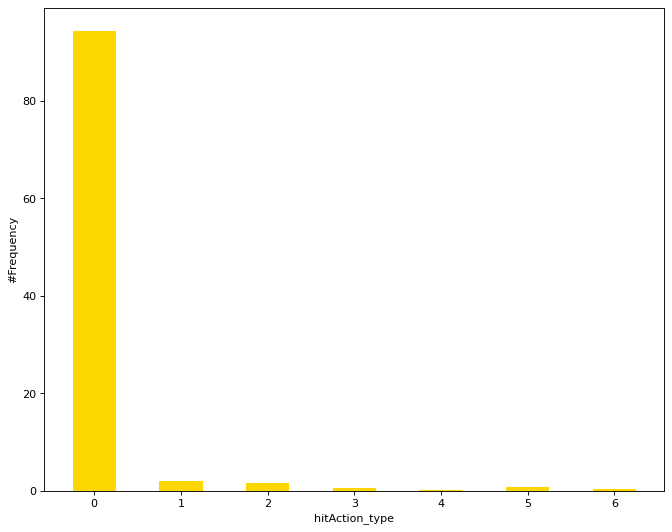

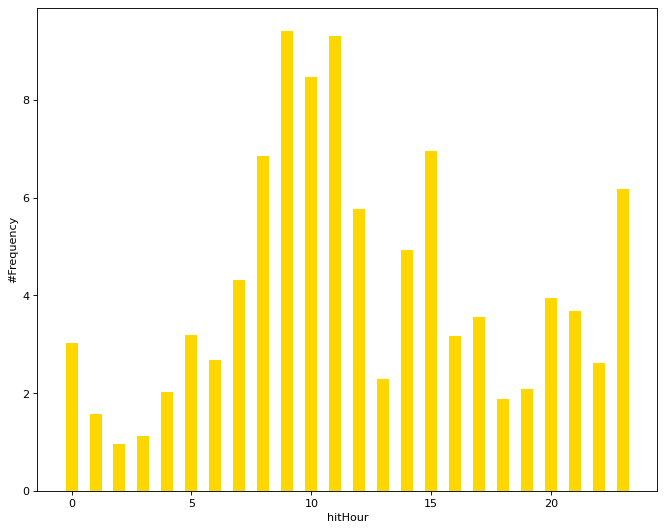

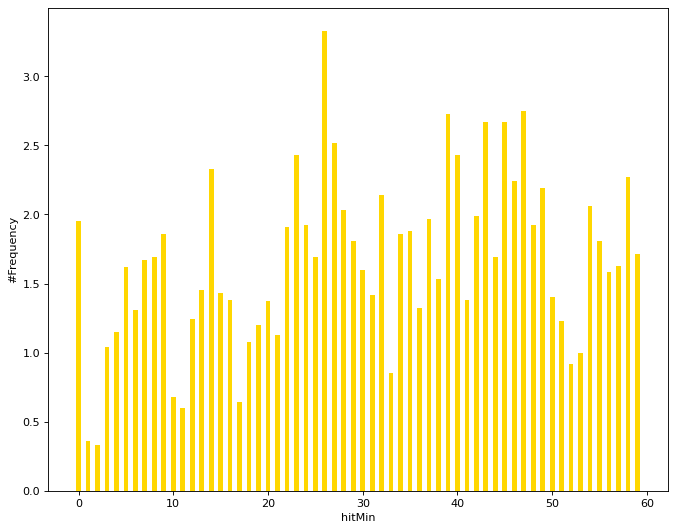

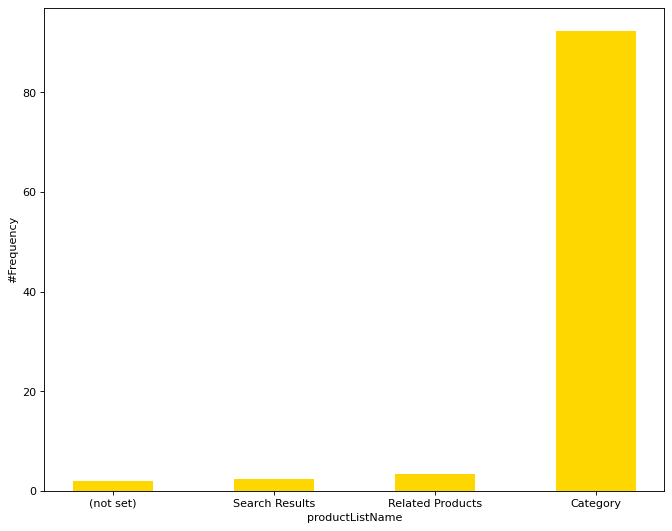

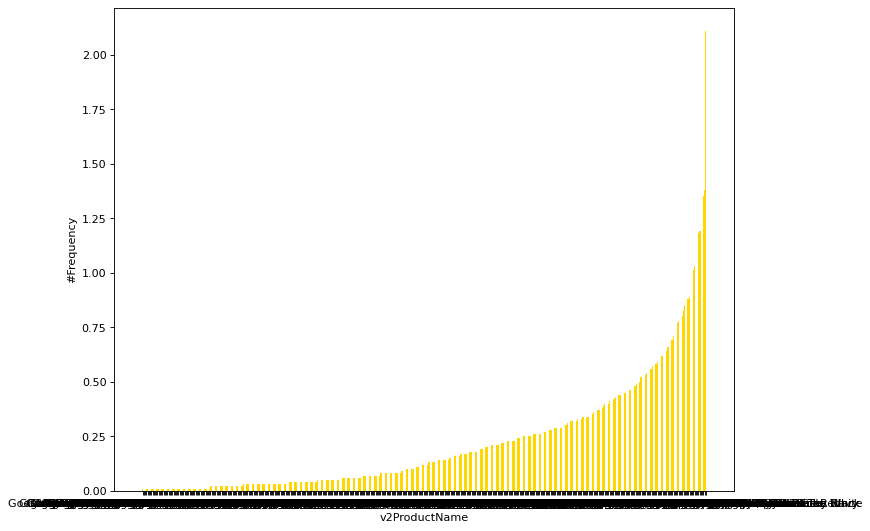

In [31]:
for col in freq_distribution_col_list:
  analysis_pd = raw_df.groupBy(col).count().withColumn('percentage',calPercentfunc(sparkf.col('count')))\
                  .orderBy('percentage')\
                  .toPandas()
  analysis_pd

  ## Ploting Bars Chart
  plt.figure(figsize=(10,8), dpi= 80)
  plt.bar(analysis_pd[col], analysis_pd['percentage'], color='gold', width=.5)

  ## Decoration
  plt.ylabel('#Frequency')
  plt.xlabel(col)

  del(analysis_pd)

In [32]:
withLowSampling_freq_distribution_col_list = ['fullVisitorId','visitId']

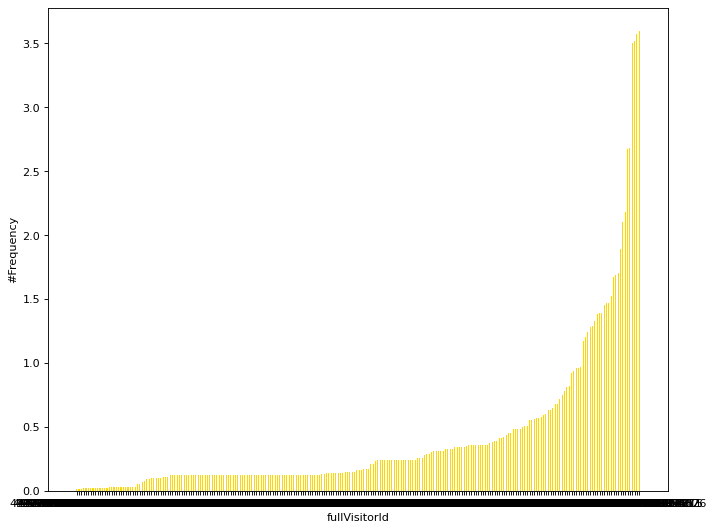

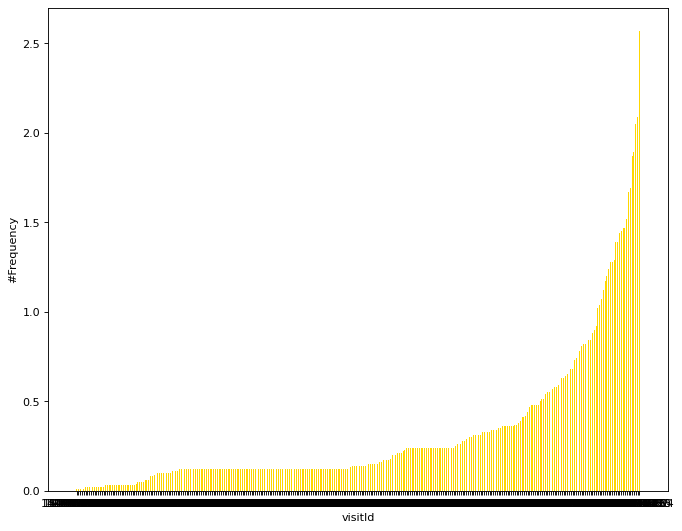

In [33]:
for col in withLowSampling_freq_distribution_col_list:
  ## การมี .withColumn() ทำการ type casting เลย ก็เพราะว่า ต้องการปรับ type ของ variables ให้สอดคล้องกับเครื่องทางสถิติที่จะนำมาใช้ EDA
  analysis_pd = raw_df.withColumn(col,sparkf.col(col).cast(StringType()))\
                  .groupBy(col).count().withColumn('percentage',calPercentfunc(sparkf.col('count')))\
                  .orderBy('percentage')\
                  .toPandas()
  analysis_pd

  ## Ploting Bars Chart
  plt.figure(figsize=(10,8), dpi= 80)
  plt.bar(analysis_pd[col], analysis_pd['percentage'], color='gold', width=.5)

  ## Decoration
  plt.ylabel('#Frequency')
  plt.xlabel(col)

  del(analysis_pd)

In [34]:
### (1) น่าสนใจมากท่ี่ Id ของข้อมูลนี้ไม่เป็น Uniform Distribution

### **2.3 Multivariate Analysis**

*แสดงความสัมพันธ์ระหว่างตัวแปร hitAction_type และ totalTransactionRevenue โดยใช้ .groupBy().count()*

In [35]:
## ลองดูความสัมพันธ์ระหว่าง hitAction_type ที่ไม่เท่ากับ 6 กับ totalTransactionRevenue โดยแจกแจงความสัมพันธ์ออกมาเป็นความถี่

In [36]:
raw_df.select(['fullVisitorId','visitId','hitAction_type','totalTransactionRevenue'])\
.filter(sparkf.col('hitAction_type') != 6).groupBy('fullVisitorId','visitId','hitAction_type','totalTransactionRevenue')\
.count().orderBy(sparkf.col('totalTransactionRevenue').desc(),sparkf.col('count').desc()).show()

+-------------------+----------+--------------+-----------------------+-----+
|      fullVisitorId|   visitId|hitAction_type|totalTransactionRevenue|count|
+-------------------+----------+--------------+-----------------------+-----+
|4995924842281653133|1486131356|             0|              128970000|   15|
|4995924842281653133|1486131356|             5|              128970000|    2|
|4995924842281653133|1486131356|             2|              128970000|    1|
|4995584940873803432|1498486477|             0|              116760000|   14|
|4995584940873803432|1498486477|             5|              116760000|    8|
|4995584940873803432|1498486477|             1|              116760000|    2|
|4995584940873803432|1498486477|             3|              116760000|    1|
|4995584940873803432|1498486477|             2|              116760000|    1|
|4989274933392395231|1487773059|             0|               59960000|   60|
|4989274933392395231|1487773059|             5|               59

In [37]:
## นับรวม count ข้างต้นแล้ว ได้กี่ observations

In [38]:
raw_df.select(['fullVisitorId','visitId','hitAction_type','totalTransactionRevenue'])\
.filter(sparkf.col('hitAction_type') != 6).groupBy('fullVisitorId','visitId','hitAction_type','totalTransactionRevenue')\
.count().agg(sparkf.sum('count')).show()

+----------+
|sum(count)|
+----------+
|      9959|
+----------+



In [39]:
## ลองดูความสัมพันธ์ระหว่าง hitAction_type ที่เท่ากับ 6 กับ totalTransactionRevenue โดยแจกแจงความสัมพันธ์ออกมาเป็นความถี่

In [40]:
raw_df.select(['fullVisitorId','visitId','hitAction_type','totalTransactionRevenue'])\
.filter(sparkf.col('hitAction_type') == 6).groupBy('fullVisitorId','visitId','hitAction_type','totalTransactionRevenue')\
.count().orderBy(sparkf.col('totalTransactionRevenue').desc(),sparkf.col('count').desc()).show()

+-------------------+----------+--------------+-----------------------+-----+
|      fullVisitorId|   visitId|hitAction_type|totalTransactionRevenue|count|
+-------------------+----------+--------------+-----------------------+-----+
|4995924842281653133|1486131356|             6|              128970000|    2|
|4995584940873803432|1498486477|             6|              116760000|    4|
|4989274933392395231|1487773059|             6|               59960000|    6|
|4988683855814257726|1492045051|             6|               50790000|    2|
|4988612949713423910|1490043910|             6|               36980000|    4|
|4993519711854402788|1487369367|             6|               34590000|    2|
|4995899860057743088|1474047117|             6|               33990000|    2|
|4993852637585406336|1494000490|             6|               33180000|    4|
|4993450863033496114|1485313789|             6|               30980000|    4|
|4990198874063509353|1477021389|             6|               29

In [41]:
## นับรวม count ข้างต้นแล้ว ได้กี่ observations

In [42]:
raw_df.select(['fullVisitorId','visitId','hitAction_type','totalTransactionRevenue'])\
.filter(sparkf.col('hitAction_type') == 6).groupBy('fullVisitorId','visitId','hitAction_type','totalTransactionRevenue')\
.count().agg(sparkf.sum('count')).show()

+----------+
|sum(count)|
+----------+
|        40|
+----------+



In [43]:
## ข้อมูลผิดปกติจากทั่วไปหรือไม่

In [44]:
raw_df.select(['fullVisitorId','visitId','hitAction_type','totalTransactionRevenue'])\
.filter(sparkf.col('hitAction_type') != 6)\
.filter(sparkf.col('totalTransactionRevenue') >0)\
.groupBy('fullVisitorId','visitId','hitAction_type','totalTransactionRevenue')\
.count().orderBy(sparkf.col('totalTransactionRevenue').desc(),sparkf.col('count').desc()).show(1000)

+-------------------+----------+--------------+-----------------------+-----+
|      fullVisitorId|   visitId|hitAction_type|totalTransactionRevenue|count|
+-------------------+----------+--------------+-----------------------+-----+
|4995924842281653133|1486131356|             0|              128970000|   15|
|4995924842281653133|1486131356|             5|              128970000|    2|
|4995924842281653133|1486131356|             2|              128970000|    1|
|4995584940873803432|1498486477|             0|              116760000|   14|
|4995584940873803432|1498486477|             5|              116760000|    8|
|4995584940873803432|1498486477|             1|              116760000|    2|
|4995584940873803432|1498486477|             3|              116760000|    1|
|4995584940873803432|1498486477|             2|              116760000|    1|
|4989274933392395231|1487773059|             0|               59960000|   60|
|4989274933392395231|1487773059|             5|               59